<a href="https://colab.research.google.com/github/duberii/pid-playground/blob/main/activities/Comparing_PID_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparing PID Methods**
---
Welcome to Particle Identification Playground! In this activity, you will compare different PID methods and use all manual PID methods to identify particles!

**Before attempting this notebook, complete all of the activities in the Getting Started section and the Particle Identification Methods section. Also, be sure to complete the following notebooks from the Advanced Topics section before attempting this notebook:**
*   Working with Experimental Data
*   Confusion Matrices

**After completing this notebook, you will be able to:**
*   Compare PID methods based on their confusion matrices
*   Identify strengths and weaknesses of commom PID methods
*   Describe the ways a dataset can affect a confusion matrix

In [ ]:
#@title Run this cell before starting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as pxp
from PIL import Image
import ipywidgets as widgets
from ipywidgets import interactive, fixed, widgets, HBox, VBox, Layout
from google.colab import output
import math
output.enable_custom_widget_manager()
def install_ROOT():
  !wget -q https://github.com/MohamedElashri/ROOT/releases/download/ubuntu/root_v6.28.04_Ubuntu_20.04.zip
  !unzip -o -qq /content/root_v6.28.04_Ubuntu_20.04.zip
  !apt-get -qq install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion &> /dev/null 2>&1
  !rm -f root_v6.28.04_Ubuntu_20.04.zip
  !wget -q http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.1f-1ubuntu2_amd64.deb
  !sudo dpkg -i libssl1.1_1.1.1f-1ubuntu2_amd64.deb &> /dev/null 2>&1
  !rm -f libssl1.1_1.1.1f-1ubuntu2_amd64.deb
  import sys
  sys.path.append("/content/root_build/")
  sys.path.append("/content/root_build/bin/")
  sys.path.append("/content/root_build/include/")
  sys.path.append("/content/root_build/lib/")
  import ctypes
  ctypes.cdll.LoadLibrary('/content/root_build/lib//libCore.so')
  ctypes.cdll.LoadLibrary('/content/root_build/lib//libThread.so')
  ctypes.cdll.LoadLibrary('/content/root_build/lib//libTreePlayer.so')
#try:
#  from ROOT import *
#except:
#  install_ROOT()
#  from ROOT import *


neutrals_sample = pd.DataFrame()
neutrals_sample['Generated As'] = np.random.choice(["Photon","KLong","Neutron"], size=100)
neutrals_sample['Identified As'] = np.random.choice(["Photon","KLong","Neutron"], size=100)

def format_labels(particle):
  if particle == "Photon":
    return r"$\gamma$"
  elif particle == "KLong":
    return r"$K_L$"
  elif particle == "Neutron":
    return r"$n$"
  elif particle == "Proton":
    return r"$p$"
  elif particle == "K+":
    return r"$K+$"
  elif particle == "Pi+":
    return r"$\pi+$"
  elif particle == "AntiMuon":
    return r"$\overline{\mu}$"
  elif particle == "Positron":
    return r"$\overline{e}$"
  elif particle == "AntiProton":
    return r"$\overline{p}$"
  elif particle == "K-":
    return r"$K-$"
  elif particle == "Pi-":
    return r"$\pi-$"
  elif particle == "Muon":
    return r"$\mu$"
  elif particle == "Electron":
    return r"$e$"
  else:
    return particle

def from_pdg(ptype):
  if int(ptype) == 11:
    return "Electron"
  elif int(ptype) == -11:
    return "Positron"
  elif int(ptype) == 13:
    return "Muon"
  elif int(ptype) == -13:
    return "AntiMuon"
  elif int(ptype) == 211:
    return "Pi+"
  elif int(ptype) == -211:
    return "Pi-"
  elif int(ptype) == 321:
    return "K+"
  elif int(ptype) == -321:
    return "K-"
  elif int(ptype) == 2212:
    return "Proton"
  elif int(ptype) == -2212:
    return "AntiProton"
  elif int(ptype) == 2112:
    return "Neutron"
  elif int(ptype) == 22:
    return "Photon"
  elif int(ptype) == 130:
    return "KLong"

def round_accuracies(num):
  new_num = round(num,2)
  if new_num == 0.00:
    return 0
  else:
    return new_num
def replace_None(value):
  if value is not None:
    return value
  else:
    return "No ID"

def most_frequent(my_list):
  new_list = [i for i in my_list if i != "No ID"]
  if len(new_list) == 0:
    return "No ID"
  else:
    return np.random.choice(new_list)

class ConfusionMatrix():
  def __init__(self, estimator, df, target="Generated As", pretty_symbols=True, title="", purity=False):
    dataset = df.copy().reset_index(drop=True)
    fig, ax = plt.subplots()
    predictions = []
    identities = []
    predictions_full = dataset.apply(estimator,axis=1)
    nRows = len(dataset.index)
    starting_index = 0
    self.purity= purity
    while starting_index < nRows - 1 :
      ending_index = starting_index + dataset['Number of Hypotheses'][starting_index]
      predictions.append(most_frequent(predictions_full[starting_index:ending_index]))
      identities.append(dataset['Generated As'][starting_index])
      starting_index = ending_index
    unique_predictions = list(set(predictions))
    unique_targets = dataset[target].unique()
    self.categories = [particle for particle in ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"] if particle in unique_predictions or particle in unique_targets]
    if "No ID" in self.categories:
      nXticks = len(self.categories)
      nYticks = len(self.categories) - 1
    else:
      nXticks = len(self.categories)
      nYticks = len(self.categories)
    self.confusion_matrix = np.zeros((nYticks,nXticks))
    for i in range(len(predictions)):
      generated_index = self.categories.index(identities[i])
      identified_index = self.categories.index(predictions[i])
      self.confusion_matrix[generated_index][identified_index] += 1
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    for i in range(len(self.confusion_matrix)):
      self.confusion_matrix[i]= self.confusion_matrix[i]/sum(self.confusion_matrix[i])
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    np.nan_to_num(self.confusion_matrix, copy=False)
    self.im_ = ax.imshow(self.confusion_matrix)
    self.text_ = None
    cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(1.0)
    self.text_ = np.empty_like(self.confusion_matrix, dtype=object)
    thresh = (self.confusion_matrix.max() + self.confusion_matrix.min()) / 2.0
    for i in range(nYticks):
      for j in range(nXticks):
        color = cmap_max if self.confusion_matrix[i][j] < thresh else cmap_min
        text_cm = round(self.confusion_matrix[i][j], 2)
        if float(text_cm) == float(0):
          text_cm = 0
        default_text_kwargs = dict(ha="center", va="center", color=color)
        text_kwargs = {**default_text_kwargs}
        self.text_[i][j] = ax.text(j, i, text_cm, **text_kwargs)
    display_labels = self.categories
    fig.colorbar(self.im_, ax=ax)
    if pretty_symbols:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=[format_labels(x) for x in self.categories],yticklabels=[format_labels(self.categories[i]) for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    else:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=self.categories,yticklabels=[self.categories[i] for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    ax.set_ylim((nYticks - 0.5, -0.5))
    self.figure_ = fig
    self.figure_.set_figheight(7)
    self.figure_.set_figwidth(7)
    self.ax_ = ax
    ax.set_title(title)

  @classmethod
  def from_predictions(self, labels, predictions, pretty_symbols=True,purity= False):
    self.purity = purity
    fig, ax = plt.subplots()
    if isinstance(predictions,pd.Series):
      self.categories = [particle for particle in ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron","No ID"] if particle in predictions.unique() or particle in labels.unique()]
    else:
      self.categories = [particle for particle in ["Photon","KLong","Neutron","Proton","K+","Pi+","AntiMuon","Positron","AntiProton","K-","Pi-","Muon","Electron", "No ID"] if particle in list(set(predictions)) or particle in list(set(labels))]
    if "No ID" in self.categories:
      nXticks = len(self.categories)
      nYticks = len(self.categories) - 1
    else:
      nXticks = len(self.categories)
      nYticks = len(self.categories)
    self.confusion_matrix = np.zeros((nYticks,nXticks))
    for i in range(len(predictions)):
      generated_index = self.categories.index(labels[i])
      identified_index = self.categories.index(predictions[i])
      self.confusion_matrix[generated_index][identified_index] += 1
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    for i in range(len(self.confusion_matrix)):
      self.confusion_matrix[i]= self.confusion_matrix[i]/sum(self.confusion_matrix[i])
    if self.purity:
      self.confusion_matrix = np.transpose(self.confusion_matrix)
    np.nan_to_num(self.confusion_matrix, copy=False)
    self.im_ = ax.imshow(self.confusion_matrix)
    cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(1.0)
    self.text_ = np.empty_like(self.confusion_matrix, dtype=object)
    thresh = (self.confusion_matrix.max() + self.confusion_matrix.min()) / 2.0
    for i in range(nYticks):
      for j in range(nXticks):
        color = cmap_max if self.confusion_matrix[i][j] < thresh else cmap_min
        text_cm = round(self.confusion_matrix[i][j], 2)
        if float(text_cm) == float(0):
          text_cm = 0
        default_text_kwargs = dict(ha="center", va="center", color=color)
        text_kwargs = {**default_text_kwargs}
        self.text_[i][j] = ax.text(j, i, text_cm, **text_kwargs)
    display_labels = self.categories
    fig.colorbar(self.im_, ax=ax)
    if pretty_symbols:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=[format_labels(x) for x in self.categories],yticklabels=[format_labels(self.categories[i]) for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    else:
      ax.set(xticks=np.arange(nXticks),yticks=np.arange(nYticks),xticklabels=self.categories,yticklabels=[self.categories[i] for i in range(nYticks)],ylabel="Generated As",xlabel="Identified As")
    ax.set_ylim((nYticks - 0.5, -0.5))
    self.figure_ = fig
    self.ax_ = ax
    self.figure_.set_figheight(7)
    self.figure_.set_figwidth(7)
    return self
  def __getitem__(self,index):
    try:
      return self.confusion_matrix[index]
    except:
      try:
        return self.confusion_matrix[self.categories.index(index)]
      except:
        return np.zeros_like(self.categories)
!wget -q -O particle_data.hdf5 https://github.com/duberii/pid-playground/raw/main/data/particle_data.hdf5
!wget -q -O SC.hdf5 https://github.com/duberii/pid-playground/raw/main/data/SC.hdf5
!wget -q -O TOF.hdf5 https://github.com/duberii/pid-playground/raw/main/data/TOF.hdf5
!wget -q -O FCal.hdf5 https://github.com/duberii/pid-playground/raw/main/data/FCal.hdf5
!wget -q -O BCal.hdf5 https://github.com/duberii/pid-playground/raw/main/data/BCal.hdf5
!wget -q -O DIRC.hdf5 https://github.com/duberii/pid-playground/raw/main/data/DIRC.hdf5
!wget -q -O FDC.hdf5 https://github.com/duberii/pid-playground/raw/main/data/FDC.hdf5
particle_data = pd.read_hdf("particle_data.hdf5")
charged_particles = particle_data.loc[particle_data['q'] != 0].copy().reset_index().drop(['index'],axis=1)
neutral_particles = particle_data.loc[particle_data['q'] == 0].copy()
SC = pd.read_hdf("SC.hdf5")
TOF = pd.read_hdf("TOF.hdf5")
BCal = pd.read_hdf("BCal.hdf5")
FCal = pd.read_hdf("FCal.hdf5")
DIRC = pd.read_hdf("DIRC.hdf5")
FDC = pd.read_hdf("FDC.hdf5")
CDC = charged_particles.dropna(subset=['CDC dEdx']).copy().reset_index(drop=True)
charged_BCal = BCal.loc[BCal['Hypothesis'] != ""].copy().reset_index(drop=True)
charged_FCal = FCal.loc[FCal['Hypothesis'] != ""].copy().reset_index(drop=True)

---
##**Comparing PID Methods**
---
In this section, we will compare the PID methods from previous notebooks. We will do this by creating a confusion matrix for each PID method. The `charged_particles` dataframe is a labeled dataset, which has all of the information necessary to perform all of the previously discussed PID methods.

**Note:** To get a good idea of how powerful each of these methods are, we have created samples in which every particle has a match associated with the detector we want to use for PID. To see the power of a PID method on a more realistic sample, you can apply the PID method to the `charged_particles` dataframe.

---
###**Ionization Energy Loss**
---
In this section, we will generate a confusion matrix for ionization energy loss in the central drift chamber (CDC), the forward drift chamber (FDC), the start counter (SC), and the time of flight detector (TOF).

####**Question #1:**
---
Below is a confusion matrix created from the function you wrote in Question #2 of the "Working with Experimental Data" notebook applied to a sample of charged particles with under 5 GeV/c in momentum, as measured by the CDC. Based on this confusion matrix, which type of particle is easiest to identify using ionization energy loss in the CDC?

**Note:** The cuts are implemented in a function called `dEdx_CDC` in case you'd like to use it later. A sample of tracks in the CDC is found in the `CDC` dataframe.

Double click to edit this cell and answer the following question: Which type of particle is easiest to identify using ionization energy loss in the CDC?

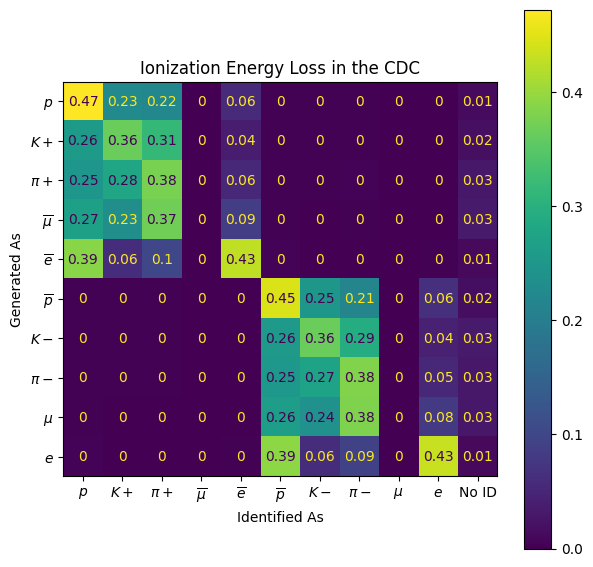

In [ ]:
# @title
def dEdx_CDC_Proton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> np.exp(-2.5*p+2.3)+1.4:
    return True
  else:
    return False

def dEdx_CDC_Kaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> np.exp(-4.9*p+2.3)+1.45 and particle['CDC dEdx'] *10**6< np.exp(-4.36*p+2.3)+2.3:
    return True
  else:
    return False

def dEdx_CDC_Pion(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> 1.59 and particle['CDC dEdx'] *10**6< 2.49:
    return True
  else:
    return False

def dEdx_CDC_Electron(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['CDC dEdx'] *10**6> 2.25 and particle['CDC dEdx'] *10**6< 3.14:
    return True
  else:
    return False

def dEdx_CDC(particle):
  if particle['Hypothesis'] == "Proton" and dEdx_CDC_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and dEdx_CDC_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and dEdx_CDC_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and dEdx_CDC_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and dEdx_CDC_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and dEdx_CDC_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and dEdx_CDC_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and dEdx_CDC_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(dEdx_CDC, CDC, title="Ionization Energy Loss in the CDC")

#####**Solution:**

Based on the confusion matrix, protons and electrons (along with antiprotons and positrons) are the easiest to identify, with 43-47% accuracy.  

####**Question #2:**
---
The `CDC` dataframe contains a sample of charged particles with a momentum between 0 and 5 GeV/c that were detected by the CDC. Complete the code below to create a dataframe of particles that have under 1 GeV/c in momentum, and create a confusion matrix for ionization energy loss cuts in the CDC using this new dataset. Then, answer the following question: Are ionization energy loss cuts more effective on higher momentum particles or lower momentum particles?

Double click to edit this cell and answer the following question: Are ionization energy loss cuts more effective on higher momentum particles or lower momentum particles?

In [ ]:
CDC['p'] = (CDC['px']**2 + CDC['py']**2  + CDC['pz']**2 )**0.5

low_momentum_charged_particles = CDC.loc[ #complete this code

ConfusionMatrix(dEdx_CDC, low_momentum_charged_particles, title="Ionization Energy Loss in the CDC (Under 1 GeV/c)")

#####**Solution:**

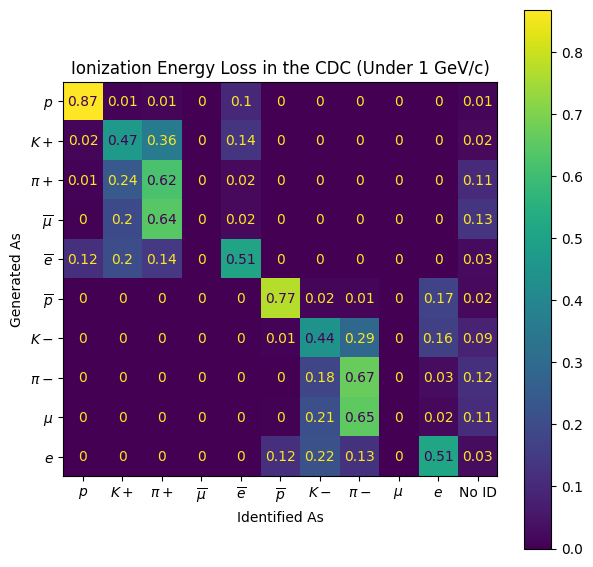

In [ ]:
CDC['p'] = (CDC['px']**2 + CDC['py']**2  + CDC['pz']**2 )**0.5

low_momentum_charged_particles = CDC.loc[CDC['p'] < 1]

ConfusionMatrix(dEdx_CDC, low_momentum_charged_particles, title="Ionization Energy Loss in the CDC (Under 1 GeV/c)")

The confusion matrix above has much higher accuracy for all particles (up to 87% for protons, which is very impressive). This suggests that ionization energy loss cuts are more powerful on low momentum particles. At higher momenta, we saw that the different stripes in an ionization energy loss plot all start to blend together, which makes ionization energy loss cuts less effective.

####**Question #3:**
---
Below is a confusion matrix created from the function you wrote in Question #3 of the "Working with Experimental Data" notebook applied to a sample of charged particles with under 5 GeV/c in momentum, as measured by the FDC. Is ionization loss in the FDC better or worse than ionization energy loss in the CDC for identifying charged particles?

**Note:** The cuts are implemented in a function called `dEdx_FDC` in case you'd like to use it later. A sample of tracks in the FDC is found in the `FDC` dataframe.

Double click to edit this cell and answer the following question: Which type of particle is easiest to identify using ionization energy loss in the FDC?

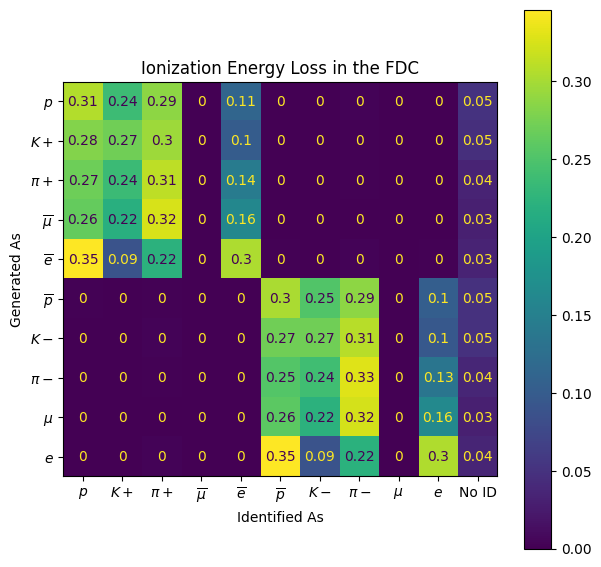

In [ ]:
# @title
def dEdx_FDC_Proton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> np.exp(-3.55*p+3.7)+1.3:
    return True
  else:
    return False

def dEdx_FDC_Kaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> np.exp(-4.4*p+2)+1.3 and particle['FDC dEdx'] *10**6< np.exp(-4.4*p+2)+2.3:
    return True
  else:
    return False

def dEdx_FDC_Pion(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> 1.45 and particle['FDC dEdx'] *10**6 < 2.6:
    return True
  else:
    return False

def dEdx_FDC_Electron(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['FDC dEdx'] *10**6> 2 and particle['FDC dEdx'] *10**6 < 3:
    return True
  else:
    return False

def dEdx_FDC(particle):
  if particle['Hypothesis'] == "Proton" and dEdx_FDC_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and dEdx_FDC_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and dEdx_FDC_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and dEdx_FDC_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and dEdx_FDC_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and dEdx_FDC_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and dEdx_FDC_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and dEdx_FDC_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(dEdx_FDC, FDC, title="Ionization Energy Loss in the FDC")

#####**Solution:**

This confusion matrix is pretty close to a random guess, so making cuts on FDC ionization energy loss is worse than making cuts on CDC ionization energy loss. In practice, we don't usually make cuts on FDC ionization energy loss for this reason- it's just not a very powerful tool.

####**Question #4:**
---
Below is a confusion matrix created from the functions you wrote in Question #4 of the "Working with Experimental Data" notebook applied to a dataframe containing tracks that are matched to a start counter hit. Based on this confusion matrix, which type of particle is easiest to identify using ionization energy loss in the start counter?

**Note:** The cuts are implemented in a function called `dEdx_SC` in case you'd like to use it later. A sample of tracks with start counter matches can be found in the `SC` dataframe.

Double click to edit this cell and answer the following question: Which type of particle is easiest to identify using ionization energy loss in the start counter?

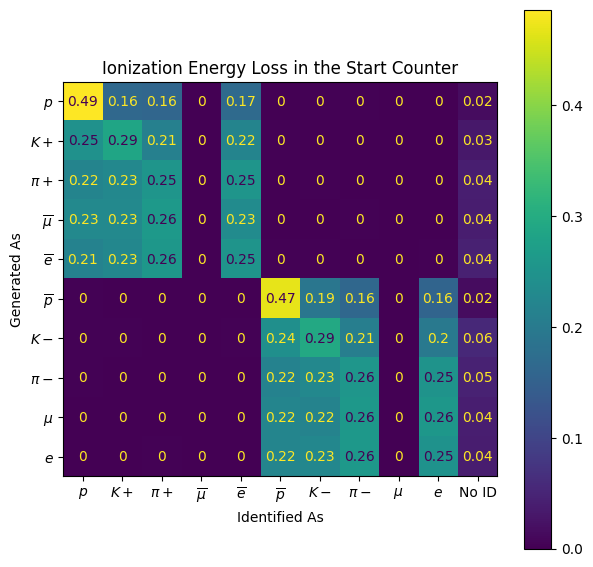

In [ ]:
# @title
def SC_dEdx_Proton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['SC dEdx'] *10**3> np.exp(-4*p+3.2)+1.6:
    return True
  else:
    return False

def SC_dEdx_Kaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['SC dEdx'] *10**3> np.exp(-4.4*p+2.7)+1.2 and particle['SC dEdx'] *10**3< np.exp(-4.6*p+3.1)+2.2:
    return True
  else:
    return False

def SC_dEdx_Pion(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['SC dEdx'] *10**3> 1.3 and particle['SC dEdx'] *10**3< 2.3:
    return True
  else:
    return False

def SC_dEdx_Electron(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['SC dEdx'] *10**3> 1.3 and particle['SC dEdx'] *10**3< 2.3:
    return True
  else:
    return False

def dEdx_SC(particle):
  if particle['Hypothesis'] == "Proton" and SC_dEdx_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and SC_dEdx_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and SC_dEdx_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and SC_dEdx_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and SC_dEdx_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and SC_dEdx_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and SC_dEdx_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and SC_dEdx_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(dEdx_SC,SC,title="Ionization Energy Loss in the Start Counter")

#####**Solution:**

Based on the confusion matrix, protons and antiprotons are much easier to identify than all other particles. This is because protons lose much more energy due to ionization (especially at lower momentum) than other particles, which makes them easier to identify.

####**Question #5:**
---
Below is the code you wrote in Question #5 of the "Working with Experimental Data" notebook. Complete the code in the cell below to create a confusion matrix for ionization energy loss cuts (which are implemented in the `dEdx_TOF` function) applied to the `TOF` dataframe. Then, answer the following questions: Which type of particle is easiest to identify using ionization energy loss in the time of flight detector?

Double click to edit this cell and answer the following questions: Which type of particle is easiest to identify using ionization energy loss in the time of flight detector?

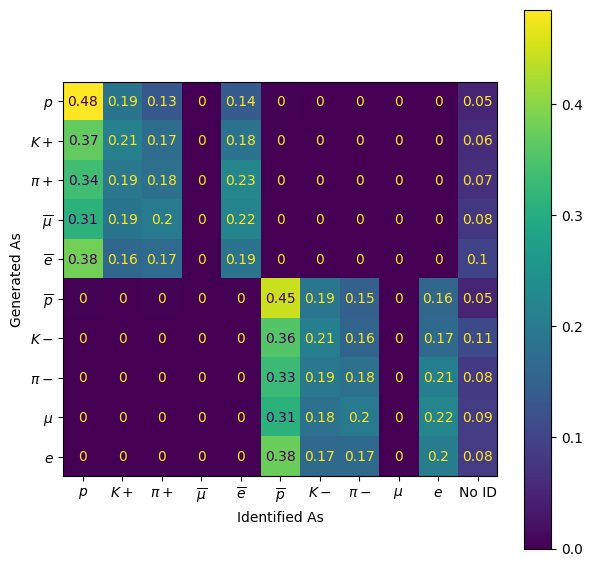

In [ ]:
# @title
def TOF_dEdx_Proton(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['TOF dEdx'] *10**4> np.exp(-2.2*p+3.9)+8.2:
    return True
  else:
    return False

def TOF_dEdx_Kaon(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['TOF dEdx'] *10**4> np.exp(-0.4*p+0.8)+7.6 and particle['TOF dEdx'] *10**4< np.exp(-0.4*p+1.4)+10:
    return True
  else:
    return False

def TOF_dEdx_Pion(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['TOF dEdx'] *10**4> 8.6 and particle['TOF dEdx'] *10**4< 11:
    return True
  else:
    return False

def TOF_dEdx_Electron(particle):
  p = (particle['px']**2 + particle['py']**2 + particle['pz']**2)**0.5
  if particle['TOF dEdx'] *10**4> 8.1 and particle['TOF dEdx'] *10**4< 11:
    return True
  else:
    return False

def dEdx_TOF(particle):
  if particle['Hypothesis'] == "Proton" and TOF_dEdx_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and TOF_dEdx_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and TOF_dEdx_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and TOF_dEdx_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and TOF_dEdx_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and TOF_dEdx_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and TOF_dEdx_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and TOF_dEdx_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(dEdx_TOF,TOF)

#####**Solution:**

As seen in the confusion matrix below, the accuracies for protons and antiprotons are much higher than the accuracies for other particles. However, it seems like a significant amount of other particles are classified as protons (or antiprotons, based on their charge), which may suggest that our cuts for protons are not restrictive enough, or that our cuts for all other particles are too strict. In this case, it could be a mix of both, but it doesn't matter in practice because we almost never make cuts on ionization energy loss in the TOF detector, since using time of flight analysis is much more powerful.

####**Question #6:**
---
The cuts in Question #5 are implemented in the `dEdx_TOF()` function, and the confusion matrix was created using the `TOF` dataframe. Complete the code in the cell below to create a confusion matrix that will provide information about the purity of each identified particle sample based on the `dEdx_TOF()` function and the `TOF` dataframe. Then, use the resulting confusion matrix to answer the following question: Which particle has the purest sample using ionization energy loss cuts in the time of flight detector?

**Hint:** Use the `purity` option of the `ConfusionMatrix` object. For more information, check the solution of Question #10 of the "Confusion Matrices" notebook.

Double click to edit this cell and answer the following questions: Which particle has the purest sample using ionization energy loss cuts in the time of flight detector?

In [ ]:
ConfusionMatrix(#complete this code

#####**Solution:**

<ipython-input-9-47f0e3744f29>:150: RuntimeWarning: invalid value encountered in divide
  self.confusion_matrix[i]= self.confusion_matrix[i]/sum(self.confusion_matrix[i])


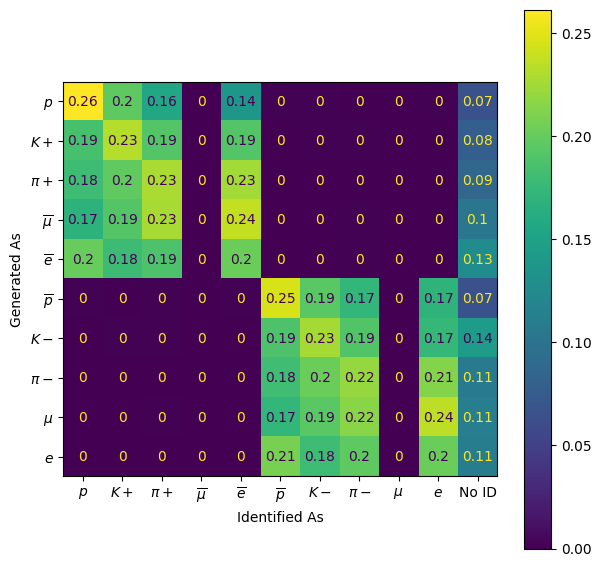

In [ ]:
ConfusionMatrix(dEdx_TOF,TOF, purity=True)

Based on this confusion matrix, the "purest" particle samples are the proton and antiproton samples, but these samples are not pure at all. All of the particle samples are under 30% pure, meaning the majority of the particles in each identified sample are not the particle we identified it as. It is clear from this that if our goal is to have extremely pure samples of particles, we shouldn't exclusively use ionization energy loss in the TOF detector.

---
###**Time of Flight**
---
In this section, we will generate a confusion matrix for time of flight (TOF) analysis in the start counter, barrel calorimeter (BCal), forward calorimeter (FCal), and forward time of flight detector (TOF).

####**Question #7:**
---
The code below creates a confusion matrix for time of flight cuts in the forward TOF detector (which you implemented in Question #6 of the "Working with Experimental Data" notebook). Based on this confusion matrix, are time of flight cuts in the forward TOF detector more accurate or less accurate than ionization energy loss cuts in the CDC (which you created a confusion matrix for in Question #1)?

**Hint:** These cuts are implemented in the `TOF_TOF` function, and the dataset we are applying these cuts to is stored in the `TOF` dataframe.

Double click to edit this cell and answer the following questions: Based on this confusion matrix, are time of flight cuts in the forward TOF detector more accurate or less accurate than ionization energy loss cuts in the CDC (which you created a confusion matrix for in Question #1)?

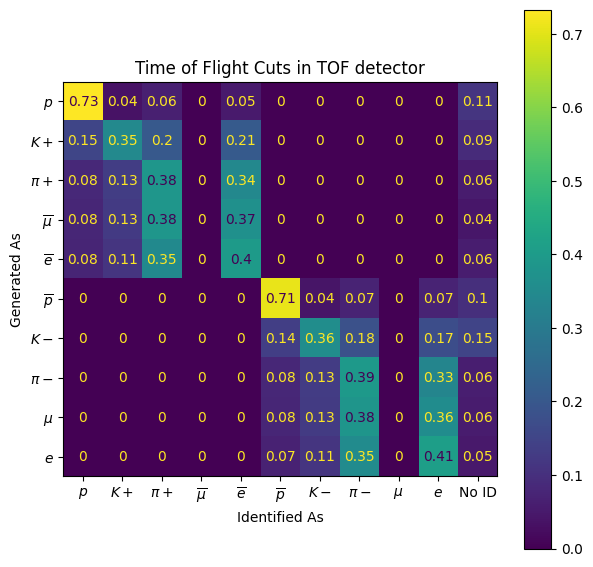

In [ ]:
# @title
def TOF_TOF_Proton(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
    return True
  else:
    return False

def TOF_TOF_Kaon(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.3:
    return True
  else:
    return False

def TOF_TOF_Pion(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def TOF_TOF_Electron(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def TOF_TOF(particle):
  if particle['Hypothesis'] == "Proton" and TOF_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and TOF_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and TOF_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and TOF_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and TOF_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and TOF_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and TOF_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and TOF_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(TOF_TOF, TOF, title= "Time of Flight Cuts in TOF detector")

#####**Solution:**

For all particles except K+, time of flight cuts in the forward TOF detector are more accurate than ionization energy loss cuts in the CDC. The biggest improvement is seen for protons and antiprotons, which are identified with over 70% accuracy in the 0-5 GeV/c momentum range.

However, note that this is not a perfect comparison- the CDC only detects particles that travel radially (towards the barrel calorimeter), while the forward TOF detector detects particles that travel in the forward direction (towards the DIRC detector and the forward calorimeter). In practice, we use both of these methods depending on which direction the particle travels.

####**Question #8:**
---
The confusion matrix in the previous part was generated using a sample of charged particles that were guaranteed to have a time of flight detector hit. However, because the forward time of flight detector only detects particles that travel in the forward direction, most particles do not interact with the time of flight detector at all. The confusion matrix below uses the exact same PID method, but now on a dataset that does not require a time of flight detector hit. What do you notice about this confusion matrix when compared to the confusion matrix from the previous part? How does the information about the dataset explain this change?

Double click to edit this cell and answer the following question: What do you notice about this confusion matrix when compared to the confusion matrix from the previous part? How does the information about the dataset explain this change?

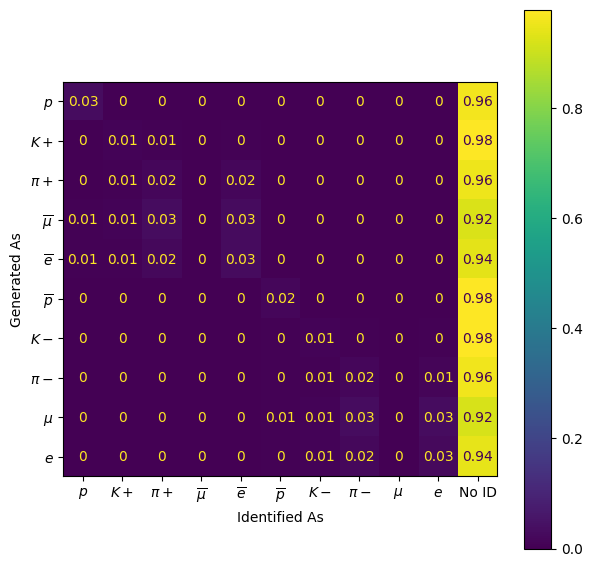

In [ ]:
# @title
def TOF_TOF_Proton(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
    return True
  else:
    return False

def TOF_TOF_Kaon(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.3:
    return True
  else:
    return False

def TOF_TOF_Pion(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def TOF_TOF_Electron(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def TOF_TOF(particle):
  if particle['Hypothesis'] == "Proton" and TOF_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and TOF_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and TOF_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and TOF_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and TOF_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and TOF_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and TOF_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and TOF_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(TOF_TOF, charged_particles, title="Time of Flight Cuts in TOF Detector")

#####**Solution:**

In this confusion matrix, the vast majority of the particles show up in the "No ID" column.

Because the previous part used a dataset in which every track had an associated time of flight detector hit, the only particles that show up in the "No ID" column are particles that have an abnormal time of flight (likely due to measurement errors), which is fairly uncommon.

In contrast, most of the hypotheses in this new dataset do not have an associated time of flight detector hit. This means that we can't even use time of flight cuts to identify these particles (at least not in the forward time of flight detector- we may be able to use time of flight in some other detector). Since none of the hypotheses survive the cuts that we make (since the cuts don't apply to them), our PID method is unable to identify the vast majority of these particles, so we get "No ID" for the majority of the generated particles.

####**Question #9:**
---
The cell below creates a confusion matrix using time of flight cuts in the barrel calorimeter. The code is exactly the code you wrote in Question #7 of the "Working with Experimental Data" notebook. Based on this confusion matrix, are time of flight cuts in the barrel calorimeter more accurate or less accurate than time of flight cuts in the forward time of flight detector (when they are available)? In other words, compare the confusion matrix in this question to the confusion matrix generated in Question #7.

Double click to edit this cell and answer the following question: Based on this confusion matrix, are time of flight cuts in the barrel calorimeter more accurate or less accurate than time of flight cuts in the forward time of flight detector (when they are available)? In other words, compare the confusion matrix in this question to the confusion matrix generated in Question #7.

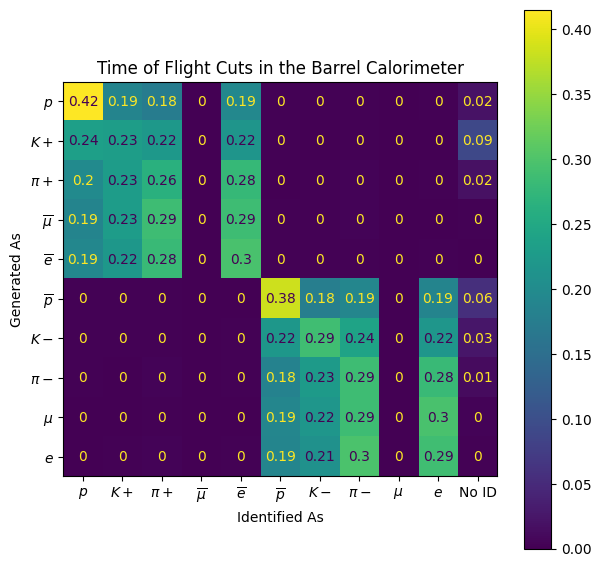

In [ ]:
# @title
def BCal_TOF_Proton(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def BCal_TOF_Kaon(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 0.75:
    return True
  else:
    return False

def BCal_TOF_Pion(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def BCal_TOF_Electron(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def TOF_BCal(particle):
  if particle['Hypothesis'] == "Proton" and BCal_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and BCal_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and BCal_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and BCal_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and BCal_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and BCal_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and BCal_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and BCal_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(TOF_BCal, charged_BCal, title="Time of Flight Cuts in the Barrel Calorimeter")

#####**Solution:**

Based on this confusion matrix, time of flight cuts in the barrel calorimeter are less accurate than time of flight cuts in the forward time of flight detector. While time of flight cuts in the time of flight detector were able to achieve over 70% accuracy for protons and antiprotons, time of flight cuts in the barrel calorimeter are only able to achieve about 40% accuracy for protons and antiprotons. For all other particles, time of flight cuts in the barrel calorimeter can only achieve under 30% accuracy, while time of flight cuts in the forward time of flight detector achieve over 35% accuracy for the same particles.

This isn't very surprising, considering how time of flight cuts work. The path lengths of the particles interacting with the barrel calorimeter tend to be much shorter than the path lengths of particles interacting with the forward time of flight detector (just based on how far away it is from the target). This means that the difference in time of flight will be larger (and thus easier to detect) for the forward time of flight detector, which means time of flight cuts in the forward TOF detector should be more accurate.

####**Question #10**:
---
Below are two confusion matrices. One is generated based on time of flight cuts in the forward calorimeter (which is very close to the forward TOF detector), and the other is generated based on time of flight cuts in the start counter (which surrounds the target of the detector). Based on the relationship between path length and accuracy of time of flight cuts, which confusion matrix corresponds to which detector?

Double click to edit this cell and answer the following question: Based on the relationship between path length and accuracy of time of flight cuts, which confusion matrix corresponds to which detector?

#####**Confusion Matrix A:**

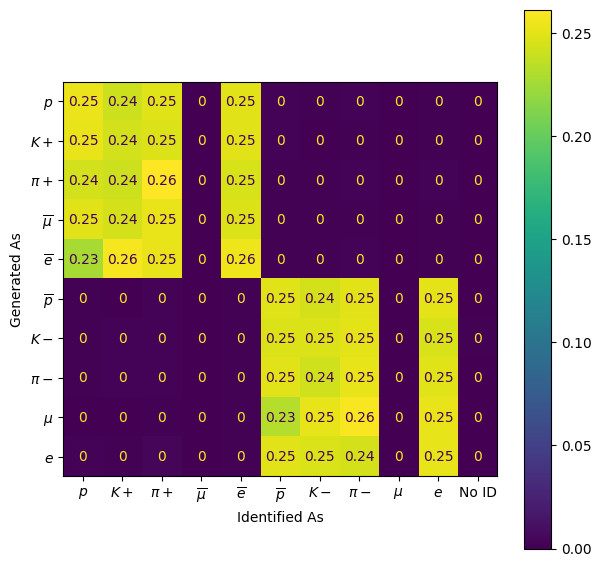

In [ ]:
# @title
def SC_TOF_Proton(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def SC_TOF_Kaon(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def SC_TOF_Pion(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def SC_TOF_Electron(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def TOF_SC(particle):
  if particle['Hypothesis'] == "Proton" and SC_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and SC_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and SC_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and SC_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and SC_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and SC_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and SC_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and SC_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(TOF_SC,SC)

#####**Confusion Matrix B:**

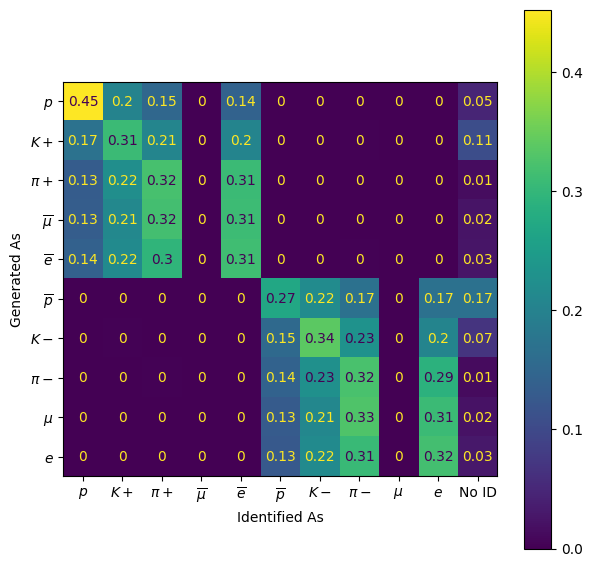

In [ ]:
# @title
def FCal_TOF_Proton(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def FCal_TOF_Kaon(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def FCal_TOF_Pion(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def FCal_TOF_Electron(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def TOF_FCal(particle):
  if particle['Hypothesis'] == "Proton" and FCal_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and FCal_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and FCal_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and FCal_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and FCal_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and FCal_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and FCal_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and FCal_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(TOF_FCal,charged_FCal)

#####**Solution:**

Time of flight cuts work better when the path length of the particle is longer. Because the forward calorimeter is so far from the target, the path lengths of the particles it detects will tend to be much longer than particles that interact with the start counter, which directly surrounds the target.

Notice that the accuracies in Confusion Matrix B are consistently larger than the accuracies in Confusion Matrix A. In fact, Confusion Matrix A closely resembles a random guess (except for muons, because there is no muon hypothesis for us to confirm). This suggests that Confusion Matrix A was generated using time of flight cuts in the start counter (which should be extremely inaccurate), and Confusion Matrix B was generated using time of flight cuts in the forward calorimeter (which should be decently accurate).

####**Question #11:**
---
Because not every particle will interact with every detector that we can make time of flight cuts in, we want to make cuts in the best detector available. In order, these detectors are:

1.   Barrel Calorimeter
2.   Forward Time of Flight
3.   Forward Calorimeter
4.   Start Counter

In Question #10 of the "Working with Experimental Data" notebook, you wrote a function that makes cuts on the "best available" detector. The confusion matrix below was generated using that function (which we called `combined_TOF`). By changing the dropdown in the cell below, you can view the confusion matrices for various functions applied to the `charged_particles` dataframe (which is just a sample of charged particles with 0-5 GeV/c in momentum, with no restrictions on interactions with detectors). Based on these confusion matrices, why do we make cuts on the best available detector instead of relying on a single detector for time of flight?

Double click to edit this cell and answer the following question: Based on these confusion matrices, why do we make cuts on the best available detector instead of relying on a single detector?

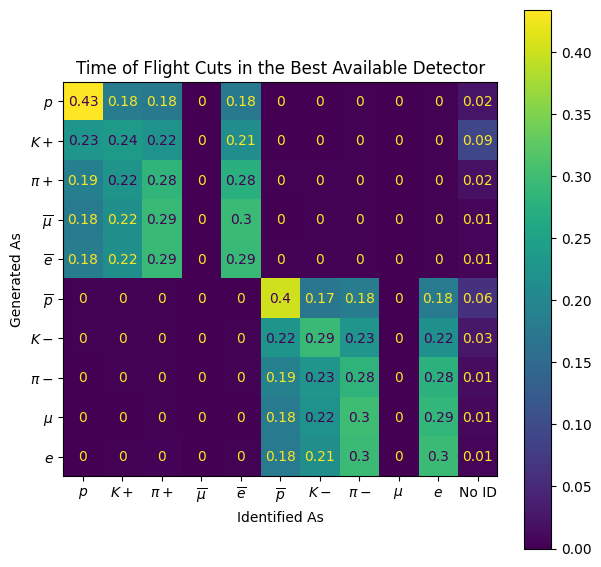

In [ ]:
# @title { "run" : "auto"}
PID_Function = "Combined_TOF" # @param ["Combined_TOF", "TOF_BCal", "TOF_TOF", "TOF_FCal", "TOF_SC"]

def FCal_TOF_Proton(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def FCal_TOF_Kaon(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def FCal_TOF_Pion(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def FCal_TOF_Electron(particle):
  if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
    return True
  else:
    return False

def TOF_FCal(particle):
  if particle['Hypothesis'] == "Proton" and FCal_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and FCal_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and FCal_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and FCal_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and FCal_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and FCal_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and FCal_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and FCal_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

def SC_TOF_Proton(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def SC_TOF_Kaon(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def SC_TOF_Pion(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def SC_TOF_Electron(particle):
  if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
    return True
  else:
    return False

def TOF_SC(particle):
  if particle['Hypothesis'] == "Proton" and SC_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and SC_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and SC_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and SC_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and SC_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and SC_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and SC_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and SC_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

def TOF_TOF_Proton(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
    return True
  else:
    return False

def TOF_TOF_Kaon(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.3:
    return True
  else:
    return False

def TOF_TOF_Pion(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def TOF_TOF_Electron(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def TOF_TOF(particle):
  if particle['Hypothesis'] == "Proton" and TOF_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and TOF_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and TOF_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and TOF_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and TOF_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and TOF_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and TOF_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and TOF_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

def TOF_TOF_Proton(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
    return True
  else:
    return False

def TOF_TOF_Kaon(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.3:
    return True
  else:
    return False

def TOF_TOF_Pion(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def TOF_TOF_Electron(particle):
  if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
    return True
  else:
    return False

def TOF_TOF(particle):
  if particle['Hypothesis'] == "Proton" and TOF_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and TOF_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and TOF_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and TOF_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and TOF_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and TOF_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and TOF_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and TOF_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"



def TOF_Proton(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.6:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def TOF_Kaon(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 0.75:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.3:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def TOF_Pion(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def TOF_Electron(particle):
  if not np.isnan(particle['BCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
      return True
    else:
      return False
  elif not np.isnan(particle['TOF Calculated Time of Flight']):
    if abs(particle['TOF Time of Flight']-particle['TOF Calculated Time of Flight']) <= 0.5:
      return True
    else:
      return False
  elif not np.isnan(particle['FCal Calculated Time of Flight']):
    if abs(particle['tShower']-particle['FCal Calculated Time of Flight']) <= 2:
      return True
    else:
      return False
  elif not np.isnan(particle['SC Calculated Time of Flight']):
    if abs(particle['SC Time of Flight']-particle['SC Calculated Time of Flight']) <= 2.5:
      return True
    else:
      return False
  else:
    return False

def Combined_TOF(particle):
  if particle['Hypothesis'] == "Proton" and TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

def BCal_TOF_Proton(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def BCal_TOF_Kaon(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 0.75:
    return True
  else:
    return False

def BCal_TOF_Pion(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def BCal_TOF_Electron(particle):
  if abs(particle['tShower']-particle['BCal Calculated Time of Flight']) <= 1:
    return True
  else:
    return False

def TOF_BCal(particle):
  if particle['Hypothesis'] == "Proton" and BCal_TOF_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and BCal_TOF_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and BCal_TOF_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and BCal_TOF_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and BCal_TOF_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and BCal_TOF_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and BCal_TOF_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and BCal_TOF_Electron(particle):
    return "Positron"
  else:
    return "No ID"

if PID_Function == "Combined_TOF":
  ConfusionMatrix(Combined_TOF, charged_particles, title="Time of Flight Cuts in the Best Available Detector")
elif PID_Function == "TOF_BCal":
  ConfusionMatrix(TOF_BCal, charged_particles, title="Time of Flight Cuts in the BCal")
elif PID_Function == "TOF_TOF":
  ConfusionMatrix(TOF_TOF, charged_particles, title="Time of Flight Cuts in the forward TOF Detector")
elif PID_Function == "TOF_FCal":
  ConfusionMatrix(TOF_FCal, charged_particles, title="Time of Flight Cuts in the FCal")
elif PID_Function == "TOF_SC":
  ConfusionMatrix(TOF_SC, charged_particles, title="Time of Flight Cuts in the Start Counter")

#####**Solution:**

Even though it would be amazing to have a forward time of flight detector hit for every track, that just isn't possible. If we only make time of flight cuts in the forward time of flight detector, the vast majority of particles will be classified as "No ID", since they didn't interact with the forward time of flight detector. By taking the best time of flight information available, we make sure that we can perform time of flight cuts on almost every charged track (since almost every charged track will have a hit in either the barrel calorimeter, time of flight detector, forward calorimeter, or the start counter). This solves the "No ID" problem, and you can see that there are fewer particles in the "No ID" column for the combined time of flight cuts than there are for the time of flight detector cuts. Picking the best available detector also means that we can avoid using the less precise detectors (such as the start counter) unless we have no other choice.

---
##**Cherenkov Radiation**
---
In this section, we will generate a confusion matrix for likelihood cuts in the DIRC detector.

####**Question #12:**
---
Below is a confusion matrix generated from the function you wrote in Question #11 of the "Working with Experimental Data" notebook applied to a sample of tracks with associated DIRC hits. Based on this confusion matrix, which particle is the easiest to identify using likelihood cuts in the DIRC detector? How does this differ from other PID methods?

**Note:** The cuts are implemented in the `DIRC_DIRC()` function and the dataset of tracks with associated DIRC hits is stored in the `DIRC` dataframe, in case you want to explore more later.

Double click to edit this cell and answer the following question: Based on this confusion matrix, which particle is the easiest to identify using likelihood cuts in the DIRC detector? How does this differ from other PID methods?

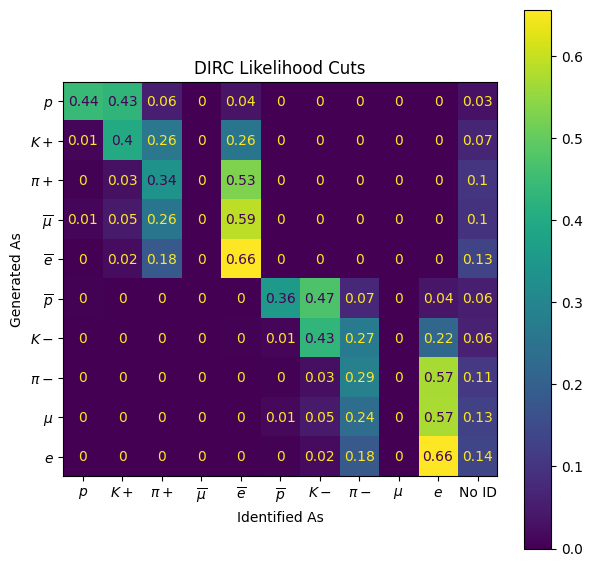

In [ ]:
# @title
def DIRC_Proton(particle):
  if particle['lp'] > max(particle['lk'], particle['lpi'],particle['lele']):
    return True
  else:
    return False

def DIRC_Kaon(particle):
  if particle['lk'] > max(particle['lp'], particle['lpi'],particle['lele']):
    return True
  else:
    return False

def DIRC_Pion(particle):
  if particle['lpi'] > max(particle['lk'], particle['lp'],particle['lele']):
    return True
  else:
    return False

def DIRC_Electron(particle):
  if particle['lele'] > max(particle['lk'], particle['lp'],particle['lpi']):
    return True
  else:
    return False

def DIRC_DIRC(particle):
  if particle['Hypothesis'] == "Proton" and DIRC_Proton(particle):
    return "Proton"
  elif particle['Hypothesis'] == "AntiProton" and DIRC_Proton(particle):
    return "AntiProton"
  elif particle['Hypothesis'] == "K+" and DIRC_Kaon(particle):
    return "K+"
  elif particle['Hypothesis'] == "K-" and DIRC_Kaon(particle):
    return "K-"
  elif particle['Hypothesis'] == "Pi+" and DIRC_Pion(particle):
    return "Pi+"
  elif particle['Hypothesis'] == "Pi-" and DIRC_Pion(particle):
    return "Pi-"
  elif particle['Hypothesis'] == "Electron" and DIRC_Electron(particle):
    return "Electron"
  elif particle['Hypothesis'] == "Positron" and DIRC_Electron(particle):
    return "Positron"
  else:
    return "No ID"

ConfusionMatrix(DIRC_DIRC, DIRC, title="DIRC Likelihood Cuts")

#####**Solution:**

Based on the confusion matrix shown above, electrons and positrons are the easiest particles to identify using the likelihoods provided by the DIRC detector. This is rare for PID methods. Most PID methods are able to easily identify protons (since they are much heavier than other stable particles), but struggle with lighter particles like electrons and pions.